# House Prices Kaggle Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from scipy import stats
import sklearn
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import learning_curve

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.kernel_ridge import KernelRidge
import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print("Libraries loaded successfully!")


Libraries loaded successfully!


In [2]:
#Load the training data
train = pd.read_csv('train.csv')

#Check the first few rows of the dataset
train.head()

#Check data types and basic info
print("Basic Info")
print("__________________________________________")
train.info()

#Check for missing values
print("__________________________________________")
print("Missing Values")
print(train.isnull().sum())



Basic Info
__________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17

In [3]:
#Load the test data
test = pd.read_csv('test.csv')

#Check the first few rows of the dataset
test.head()

#Check data types and basic info
print("Basic Info")
print("__________________________________________")
test.info()

#Check for missing values
print("__________________________________________")
print("Missing Values")
print(test.isnull().sum())

Basic Info
__________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17

## EDA Process

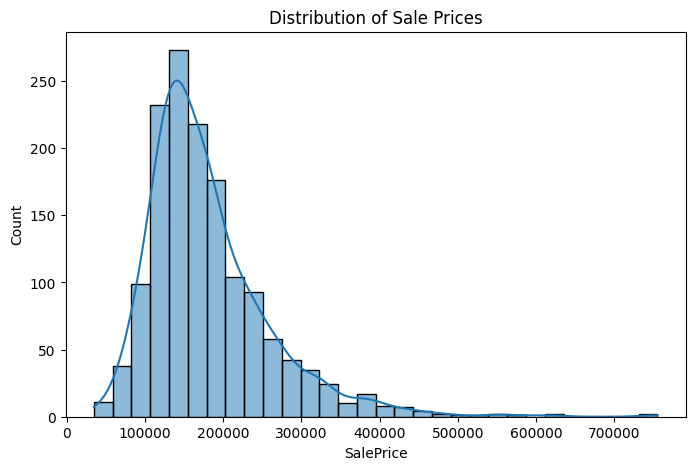

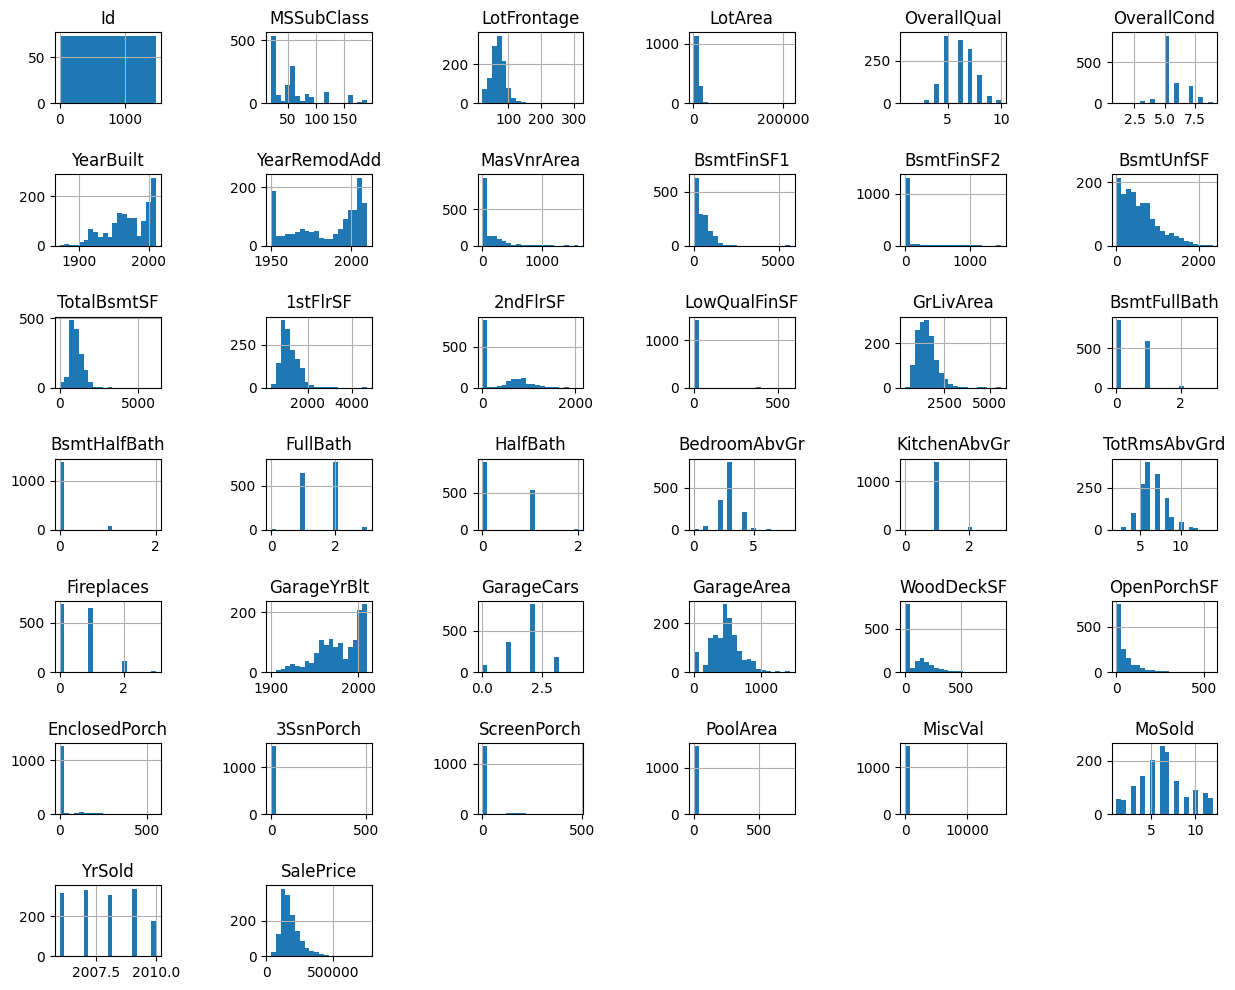

In [4]:
# 1. Plot histogram for SalePrice

plt.figure(figsize=(8,5)) 
# Set the figure size

sns.histplot(train['SalePrice'], kde=True, bins=30)
# Plot the historgram with KDE(Kernal Density Estimate)

plt.title('Distribution of Sale Prices') 
# Add title to the plot

plt.show() # Display the plot

# 2. Plot histograms for numeric features
num_features = train.select_dtypes(include=['int64', 'float64']).columns 
# Select numeric columns

train[num_features].hist(figsize=(15,12), bins=20)
# Plot histograms for all numeric columns
plt.subplots_adjust(hspace=1, wspace=1)# Increase vertical (hspace) and horizontal (wspace) spacing
plt.show() # Display the plot


### Calculating Correlation

In [5]:
# Calculate the correlation matrix
numeric_columns = train.select_dtypes(include=['int64', 'float64'])

# Calculate the correlation matrix for numeric columns
corr_matrix = numeric_columns.corr()

# Display the correlation matrix
#print(corr_matrix)

# Get the correlation of each feature with 'SalePrice'
corr_with_target = corr_matrix['SalePrice']

# Sort the correlations in descending order
corr_with_target_sorted = corr_with_target.sort_values(ascending=False)

# Display the sorted correlations
print(corr_with_target_sorted)


SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

### Finding Outliers

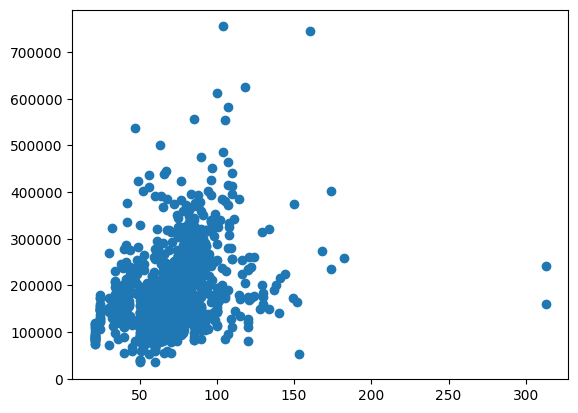

In [6]:
plt.scatter(x='LotFrontage', y='SalePrice', data=train)

In [7]:
# Create a pivot table
pivot = train.pivot_table(index="HouseStyle", columns="MSSubClass", aggfunc="size", fill_value=0)

# Display the pivot table
pivot

MSSubClass,20,30,40,45,50,60,70,75,80,85,90,120,160,180,190
HouseStyle,,,,,,,,,,,,,,,
1.5Fin,0,1,0,0,141,0,0,0,0,0,4,0,0,0,8
1.5Unf,0,1,0,12,0,0,0,0,0,0,0,0,0,0,1
1Story,534,67,4,0,0,0,0,0,0,0,29,86,0,0,6
2.5Fin,0,0,0,0,0,0,1,6,0,0,0,0,0,0,1
2.5Unf,0,0,0,0,0,0,0,9,0,0,0,0,0,0,2
2Story,1,0,0,0,3,298,59,1,0,0,9,0,63,0,11
SFoyer,0,0,0,0,0,0,0,0,0,20,9,1,0,7,0
SLvl,1,0,0,0,0,1,0,0,58,0,1,0,0,3,1


In [8]:
# Count occurrences of each combination
train_grouped = train.groupby(["HouseStyle", "MSSubClass"]).size().reset_index(name="Count")

# Display the relationship
train_grouped


,HouseStyle,MSSubClass,Count
0,1.5Fin,30,1
1,1.5Fin,50,141
2,1.5Fin,90,4
3,1.5Fin,190,8
4,1.5Unf,30,1
5,1.5Unf,45,12
6,1.5Unf,190,1
7,1Story,20,534
8,1Story,30,67
9,1Story,40,4


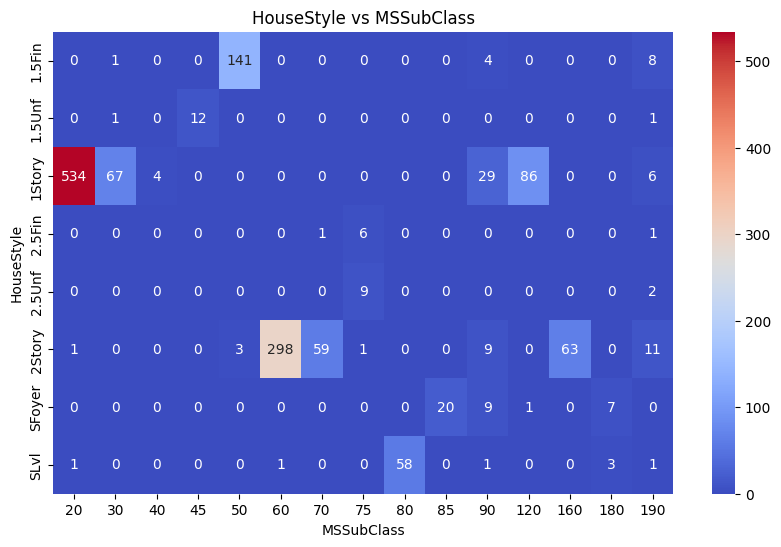

In [9]:
plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap="coolwarm", annot=True, fmt="d")
plt.title("HouseStyle vs MSSubClass")
plt.show()

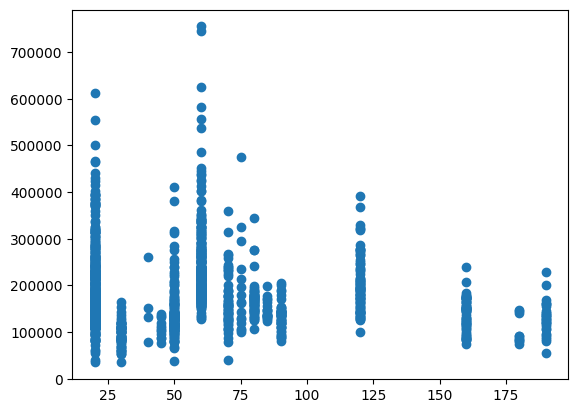

In [10]:
plt.scatter(x='MSSubClass', y='SalePrice', data=train)

In [11]:
train.query('LotFrontage > 300')
#Drop 935, 1299

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
934,935,20,RL,313.0,27650,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,11,2008,WD,Normal,242000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


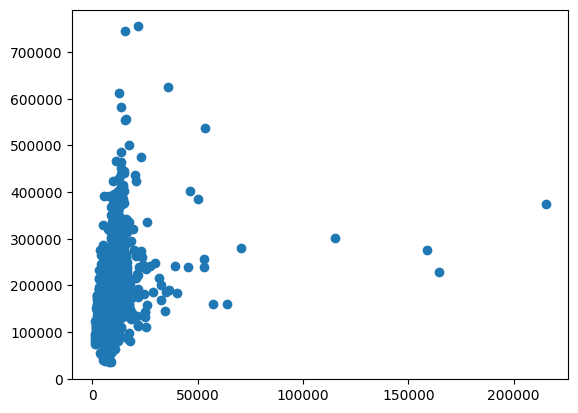

In [12]:
plt.scatter(x='LotArea', y='SalePrice', data=train)

In [13]:
train.query('LotArea > 55000')
#Drop 250, 314, 336, 707
#Maybe 1397

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
249,250,50,RL,NaN,159000,Pave,NaN,IR2,Low,AllPub,...,0,NaN,NaN,Shed,500,6,2007,WD,Normal,277000
313,314,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000
335,336,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950
451,452,20,RL,62.0,70761,Pave,NaN,IR1,Low,AllPub,...,0,NaN,NaN,NaN,0,12,2006,WD,Normal,280000
706,707,20,RL,NaN,115149,Pave,NaN,IR2,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,302000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
1396,1397,20,RL,NaN,57200,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,160000


In [14]:
pd.Series(stats.zscore(train['LotArea']), index=train.index).sort_values().tail(10)

384      4.268474
457      4.280500
769      4.308262
1396     4.678682
1298     5.348867
451      6.037793
706     10.486449
249     14.881285
335     15.448542
313     20.518273
dtype: float64

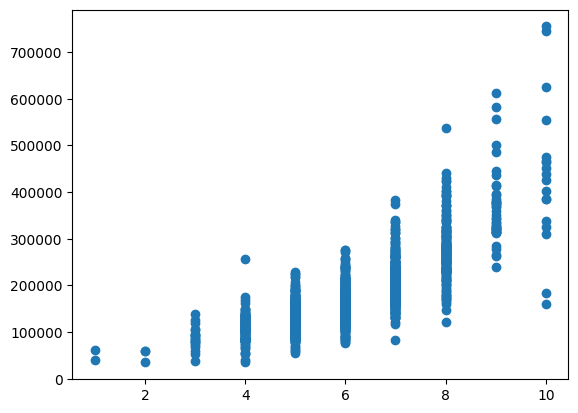

In [15]:
plt.scatter(x='OverallQual', y='SalePrice', data=train)

In [16]:
train.query('OverallQual == 10')
#maybe 524

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
58,59,60,RL,66.0,13682,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,10,2006,New,Partial,438780
185,186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000
224,225,20,RL,103.0,13472,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,386250
389,390,60,RL,96.0,12474,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2008,New,Partial,426000
440,441,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,555000
515,516,20,RL,94.0,12220,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2009,New,Partial,402861
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
583,584,75,RM,75.0,13500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,325000
591,592,60,RL,97.0,13478,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,ConLI,Normal,451950
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000


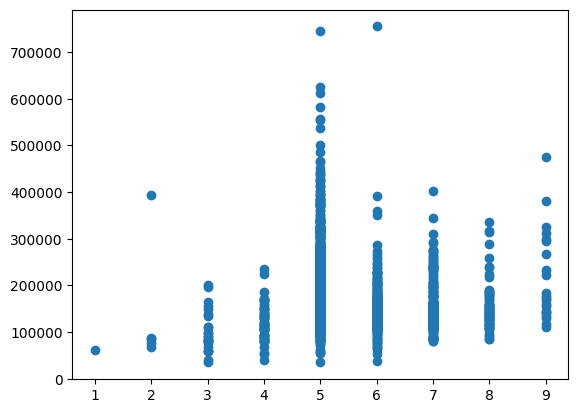

In [17]:
plt.scatter(x='OverallCond', y='SalePrice', data=train)

In [18]:
#1 
#train.query ('OverallCond == 2')
#2 
#train.query('OverallCond == 5 & SalePrice > 700000')
#3
train.query('OverallCond == 6 & SalePrice > 700000')
#1. 379, 2. 1183, 3. 692

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000


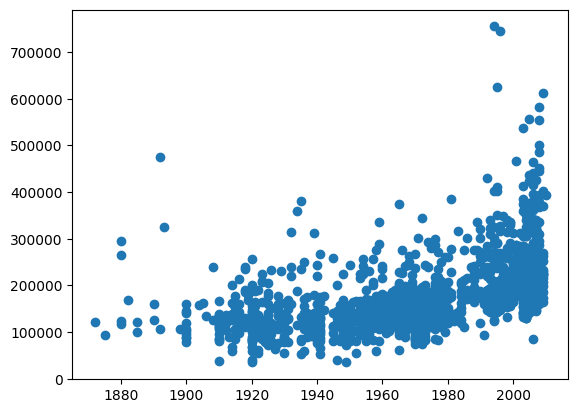

In [19]:
plt.scatter(x='YearBuilt', y='SalePrice', data=train)

In [20]:
train.query('YearBuilt < 1900 & SalePrice > 400000')
#186

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
185,186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000


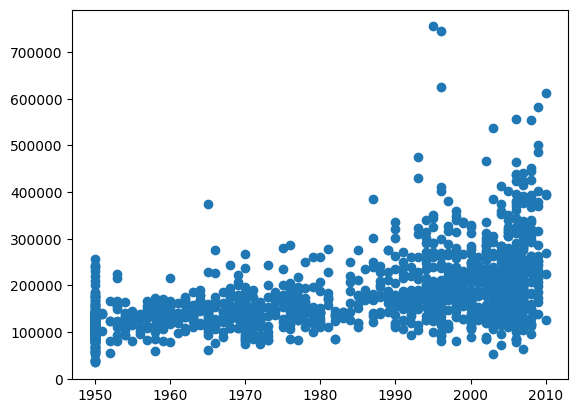

In [21]:
plt.scatter(x='YearRemodAdd', y='SalePrice', data=train)

In [22]:
train.query('YearRemodAdd < 1970 & SalePrice > 300000')
#314

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
313,314,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000


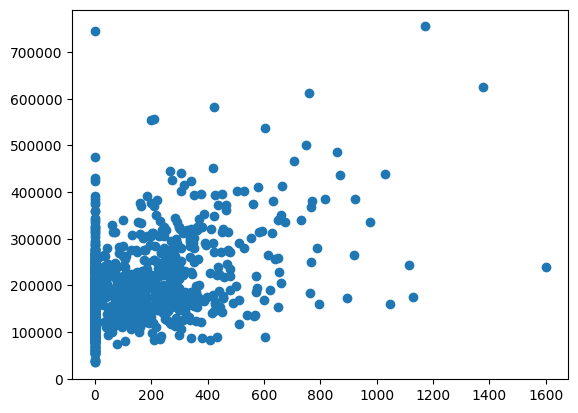

In [23]:
plt.scatter(x='MasVnrArea', y='SalePrice', data=train)

In [24]:
train.query('MasVnrArea > 1500')
#298

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
297,298,60,FV,66.0,7399,Pave,Pave,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,239000


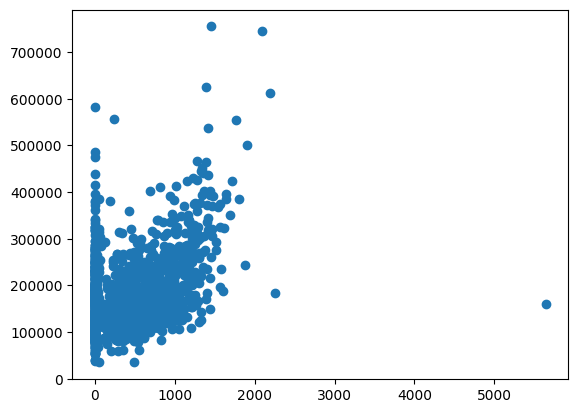

In [25]:
plt.scatter(x='BsmtFinSF1', y='SalePrice', data=train)

In [26]:
train.query('BsmtFinSF1 > 5000')
#1299

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


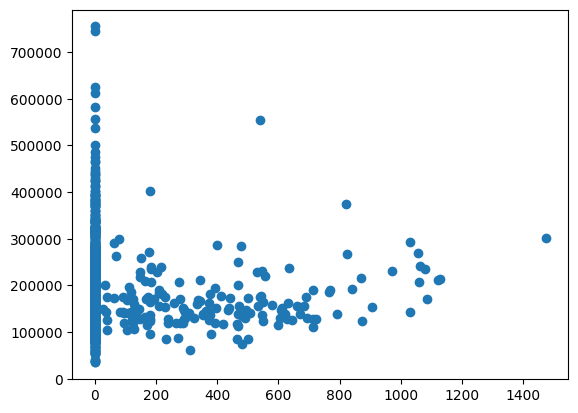

In [27]:
plt.scatter(x='BsmtFinSF2', y='SalePrice', data=train)

In [28]:
train.query('BsmtFinSF2 > 400 & SalePrice > 500000')
#441


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
440,441,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,555000


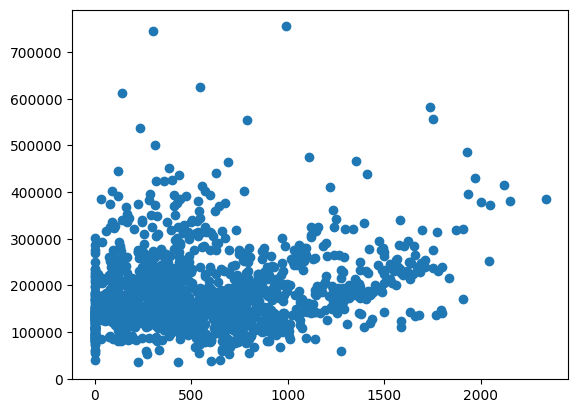

In [29]:
plt.scatter(x='BsmtUnfSF', y='SalePrice', data=train)

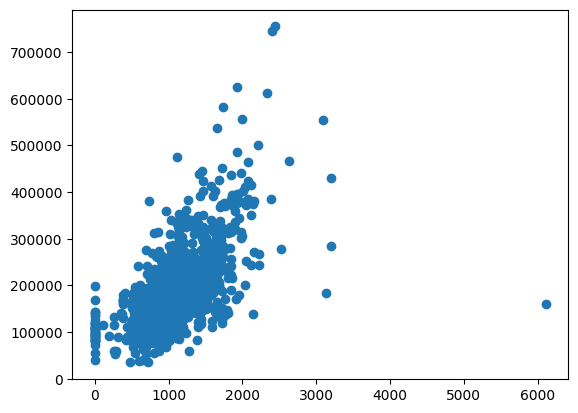

In [30]:
plt.scatter(x='TotalBsmtSF', y='SalePrice', data=train)

In [31]:
train.query('TotalBsmtSF > 5000')
#1299

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


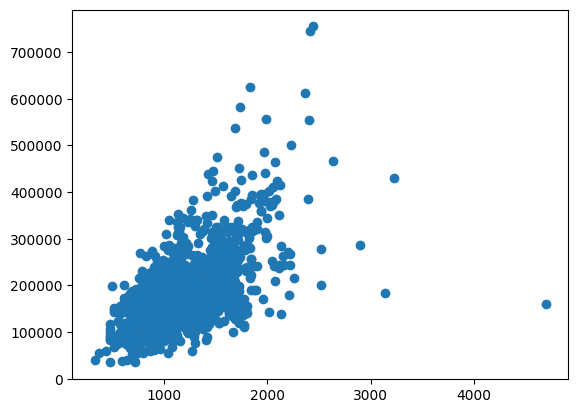

In [32]:
plt.scatter(x='1stFlrSF', y='SalePrice', data=train)

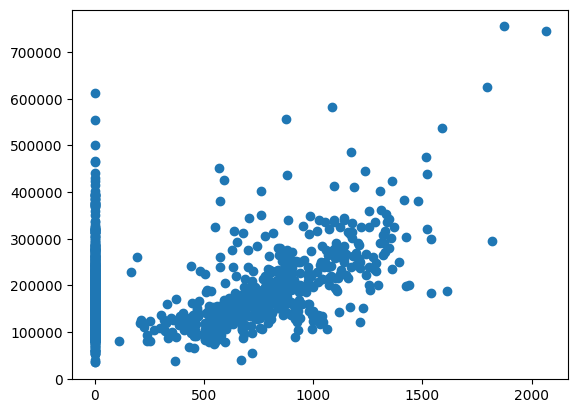

In [33]:
plt.scatter(x='2ndFlrSF', y='SalePrice', data=train)

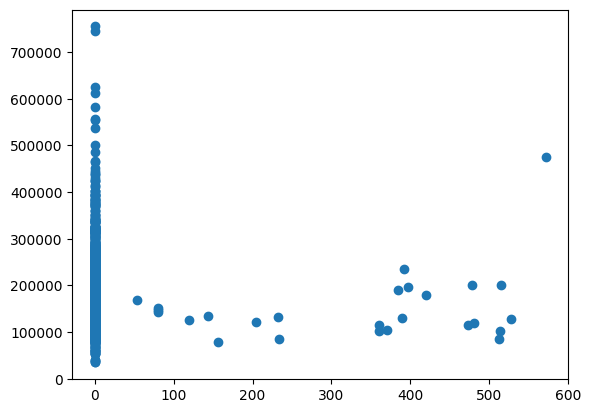

In [34]:
plt.scatter(x='LowQualFinSF', y='SalePrice', data=train)

In [35]:
train.query('LowQualFinSF > 500')
#186

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
88,89,50,C (all),105.0,8470,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,10,2009,ConLD,Abnorml,85000
170,171,50,RM,NaN,12358,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,128500
185,186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000
635,636,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml,200000
1009,1010,50,RL,60.0,6000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,102000


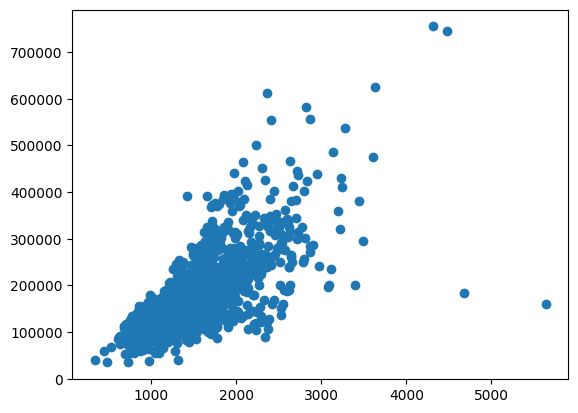

In [36]:
plt.scatter(x='GrLivArea', y='SalePrice', data=train)

In [37]:
train.query('GrLivArea > 4000')
#1299, 524

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


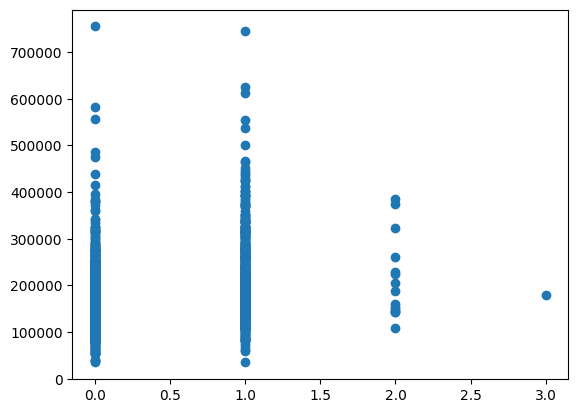

In [38]:
plt.scatter(x='BsmtFullBath', y='SalePrice', data=train)

In [39]:
train.query('BsmtFullBath == 3')
#739

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
738,739,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,179000


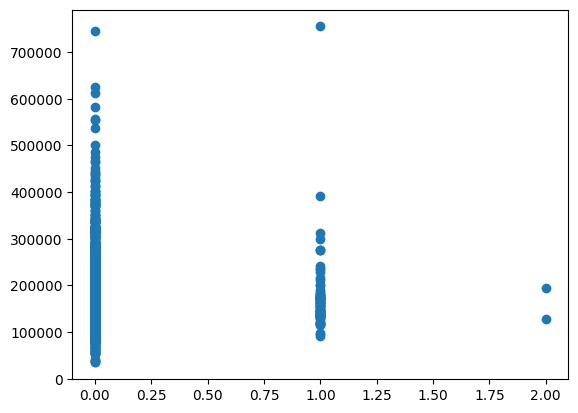

In [40]:
plt.scatter(x='BsmtHalfBath', y='SalePrice', data=train)

In [41]:
train.query('BsmtHalfBath == 2')
#598, 955

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
597,598,120,RL,53.0,3922,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2007,New,Partial,194201
954,955,90,RL,35.0,9400,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2006,WD,AdjLand,127500


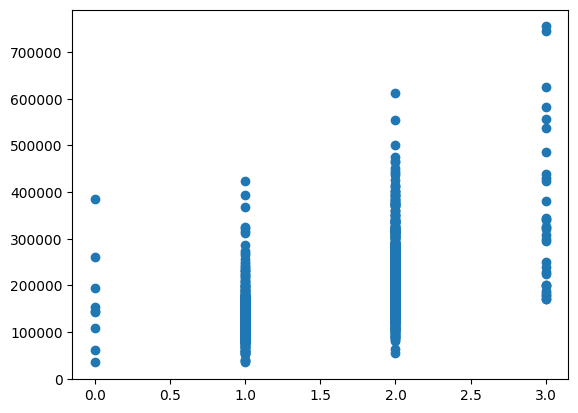

In [42]:
plt.scatter(x='FullBath', y='SalePrice', data=train)

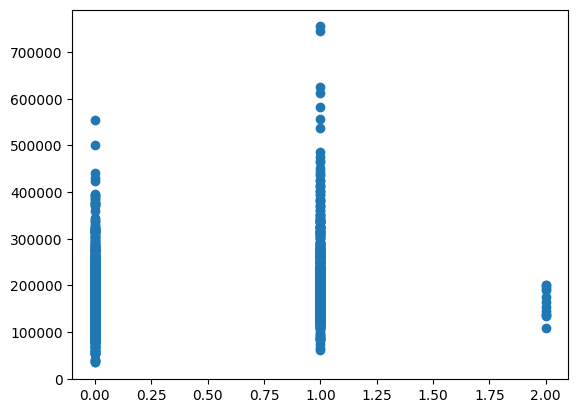

In [43]:
plt.scatter(x='HalfBath', y='SalePrice', data=train)

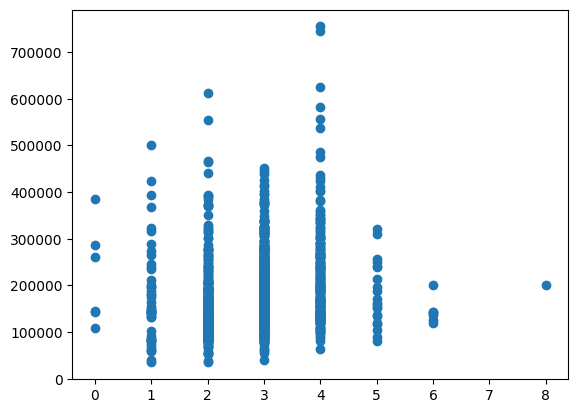

In [44]:
plt.scatter(x='BedroomAbvGr', y='SalePrice', data=train)

In [45]:
train.query('BedroomAbvGr == 8')
#636

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
635,636,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml,200000


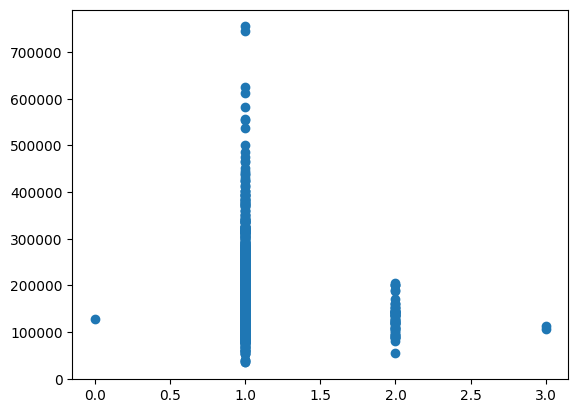

In [46]:
plt.scatter(x='KitchenAbvGr', y='SalePrice', data=train)

In [47]:
train.query('KitchenAbvGr == 3')
#49, 810

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
48,49,190,RM,33.0,4456,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,New,Partial,113000
809,810,75,RM,90.0,8100,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,11,2009,WD,Normal,106000


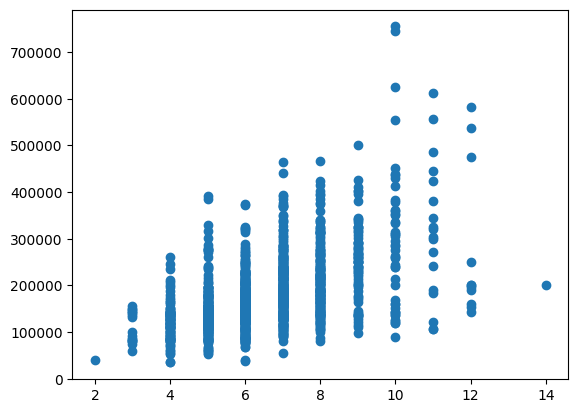

In [48]:
plt.scatter(x='TotRmsAbvGrd', y='SalePrice', data=train)

In [49]:
train.query('TotRmsAbvGrd == 14')
#636

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
635,636,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml,200000


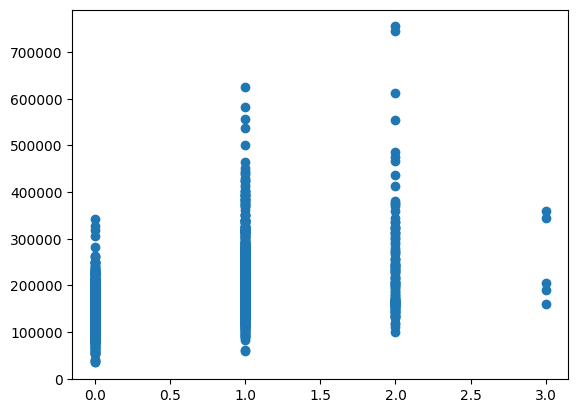

In [50]:
plt.scatter(x='Fireplaces', y='SalePrice', data=train)

In [51]:
train.query('Fireplaces == 3')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
166,167,20,RL,NaN,10708,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,11,2009,COD,Normal,190000
309,310,20,RL,90.0,12378,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2006,WD,Normal,360000
605,606,60,RL,85.0,13600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2009,WD,Normal,205000
642,643,80,RL,75.0,13860,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,7,2009,WD,Normal,345000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


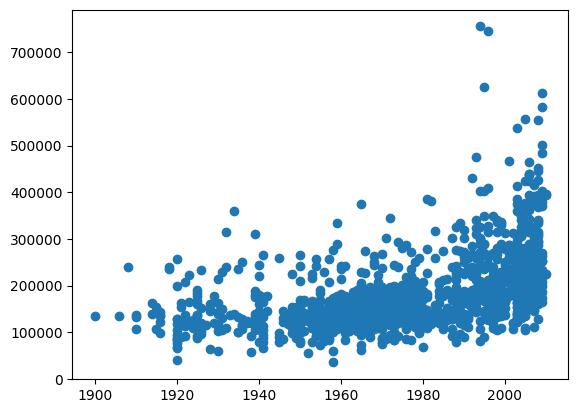

In [52]:
plt.scatter(x='GarageYrBlt', y='SalePrice', data=train)

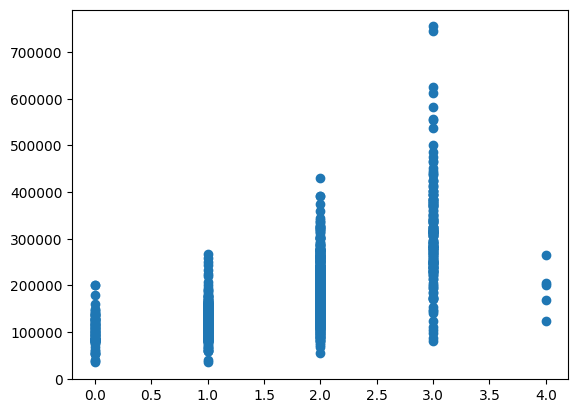

In [53]:
plt.scatter(x='GarageCars', y='SalePrice', data=train)

In [54]:
train.query('GarageCars == 4')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
420,421,90,RM,78.0,7060,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2008,WD,Alloca,206300
747,748,70,RM,65.0,11700,Pave,Pave,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,265979
1190,1191,190,RL,NaN,32463,Pave,NaN,Reg,Low,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,168000
1340,1341,20,RL,70.0,8294,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,6,2007,WD,Normal,123000
1350,1351,90,RL,91.0,11643,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2009,WD,Normal,200000


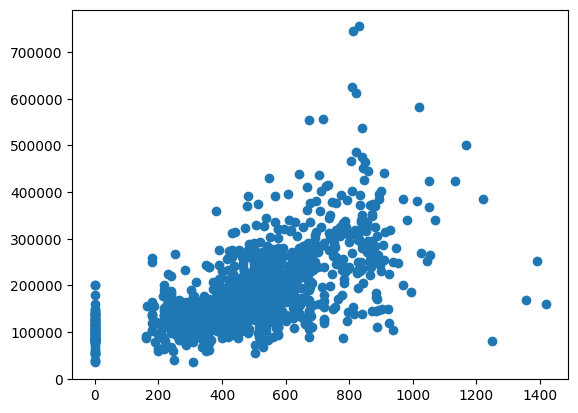

In [55]:
plt.scatter(x='GarageArea', y='SalePrice', data=train)

In [56]:
train.query('GarageArea > 1200 & GarageArea < 1400')
#1299, 1062, 1191

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
581,582,20,RL,98.0,12704,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2009,New,Partial,253293
825,826,20,RL,114.0,14803,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,New,Partial,385000
1061,1062,30,C (all),120.0,18000,Grvl,NaN,Reg,Low,AllPub,...,0,NaN,NaN,Shed,560,8,2008,ConLD,Normal,81000
1190,1191,190,RL,NaN,32463,Pave,NaN,Reg,Low,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,168000


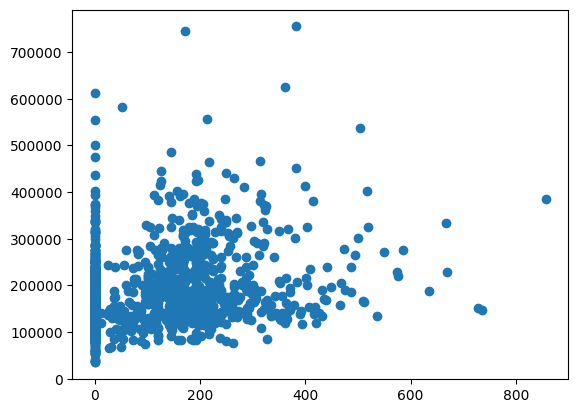

In [57]:
plt.scatter(x='WoodDeckSF', y='SalePrice', data=train)

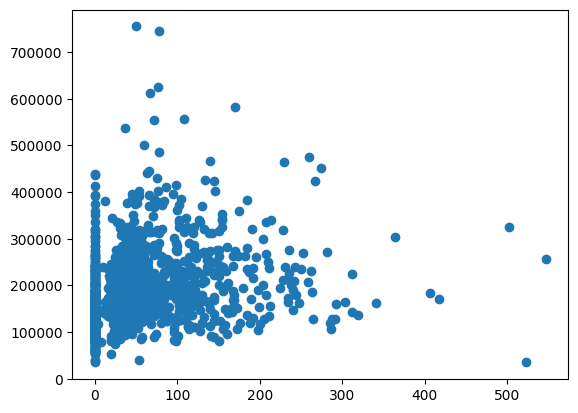

In [58]:
plt.scatter(x='OpenPorchSF', y='SalePrice', data=train)

In [59]:
train.query('OpenPorchSF > 500')
#496

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
495,496,30,C (all),60.0,7879,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,11,2009,WD,Abnorml,34900
583,584,75,RM,75.0,13500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,325000
1328,1329,50,RM,60.0,10440,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,1150,6,2008,WD,Normal,256000


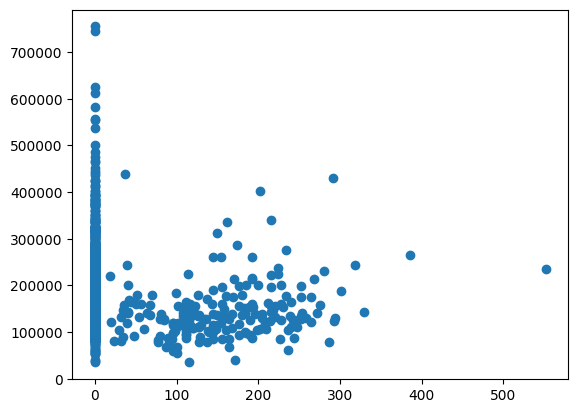

In [60]:
plt.scatter(x='EnclosedPorch', y='SalePrice', data=train)

In [61]:
train.query('EnclosedPorch > 500')
#198

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
197,198,75,RL,174.0,25419,Pave,NaN,Reg,Lvl,AllPub,...,512,Ex,GdPrv,NaN,0,3,2006,WD,Abnorml,235000


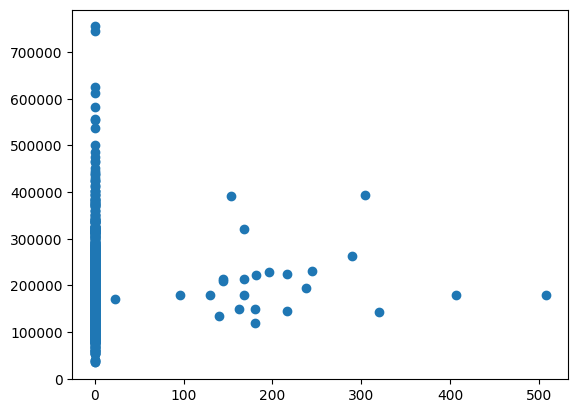

In [62]:

plt.scatter(x='3SsnPorch', y='SalePrice', data=train)

In [63]:
train.query('`3SsnPorch` > 500')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
205,206,20,RL,99.0,11851,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,180500


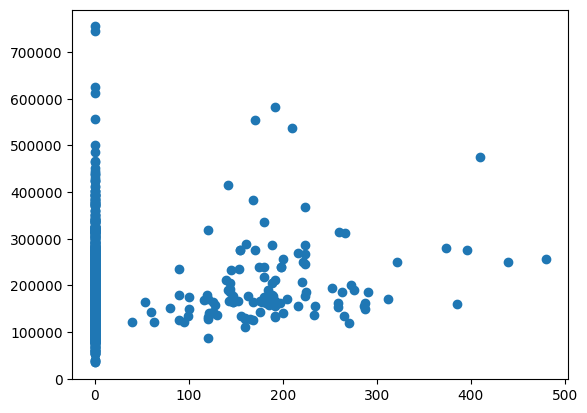

In [64]:

plt.scatter(x='ScreenPorch', y='SalePrice', data=train)

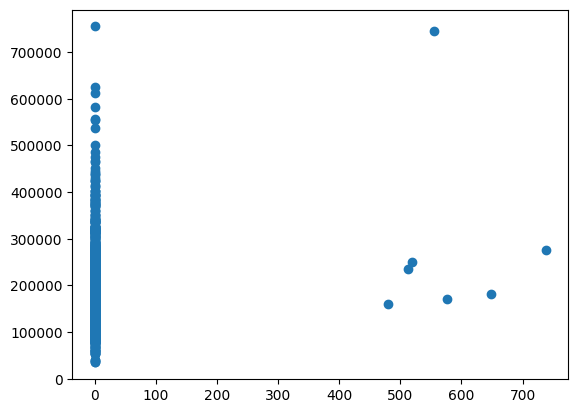

In [65]:

plt.scatter(x='PoolArea', y='SalePrice', data=train)

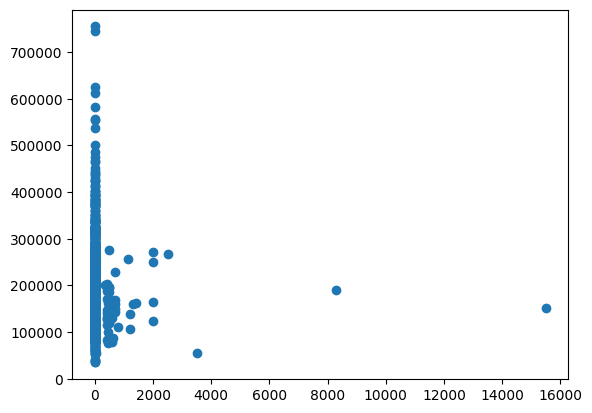

In [66]:

plt.scatter(x='MiscVal', y='SalePrice', data=train)

In [67]:
train.query('MiscVal > 0')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
16,17,20,RL,NaN,11241,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,700,3,2010,WD,Normal,149000
17,18,90,RL,72.0,10791,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,Shed,500,10,2006,WD,Normal,90000
51,52,50,RM,52.0,6240,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,400,9,2006,WD,Normal,114500
84,85,80,RL,NaN,8530,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,700,5,2009,WD,Normal,168500
95,96,60,RL,NaN,9765,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,NaN,Shed,480,4,2009,WD,Normal,185000
98,99,30,RL,85.0,10625,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,Shed,400,5,2010,COD,Abnorml,83000
99,100,20,RL,77.0,9320,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,400,1,2010,WD,Normal,128950
106,107,30,RM,60.0,10800,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,NaN,Shed,450,8,2007,WD,Normal,100000


In [68]:
train['MiscFeature'].unique()

array([nan, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

In [69]:
train['Alley'].unique()

array([nan, 'Grvl', 'Pave'], dtype=object)

In [70]:
train['Alley'].fillna('No', inplace=True)
test['Alley'].fillna('No', inplace=True)

### Handling Missing Values

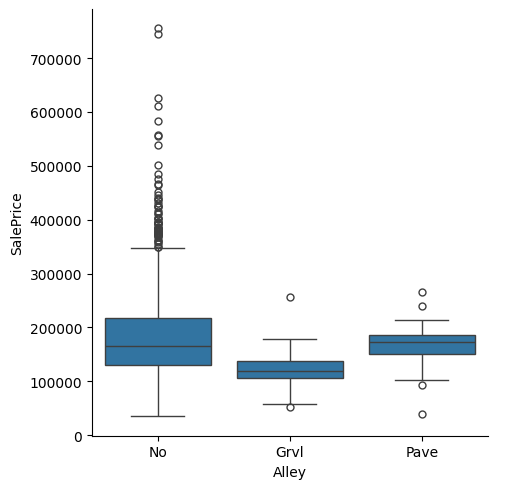

In [71]:
sns.catplot(data=train, x="Alley", y="SalePrice", kind="box")

In [72]:
train['Fence'].unique()

array([nan, 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'], dtype=object)

In [73]:
train['Fence'].fillna('No', inplace=True)
test['Fence'].fillna('No', inplace=True)

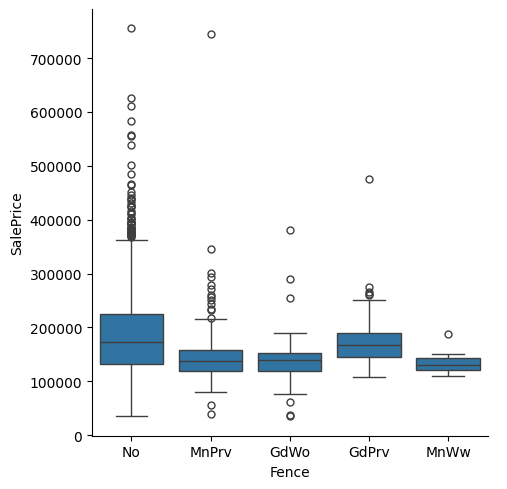

In [74]:
sns.catplot(data=train, x="Fence", y="SalePrice", kind="box")

In [75]:
train['MasVnrType'].unique()

array(['BrkFace', nan, 'Stone', 'BrkCmn'], dtype=object)

In [76]:
train['MasVnrType'].fillna('No', inplace=True)
test['MasVnrType'].fillna('No', inplace=True)

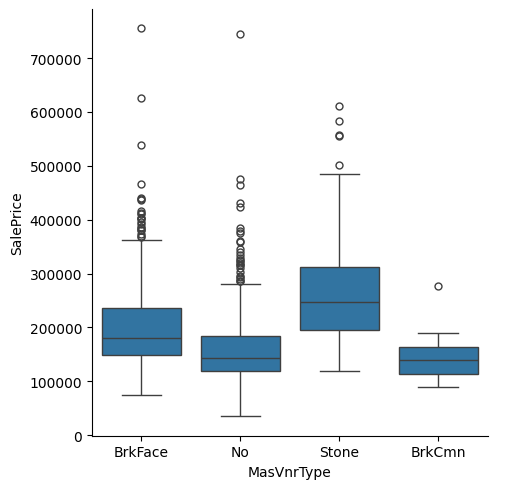

In [77]:
sns.catplot(data=train, x="MasVnrType", y="SalePrice", kind="box")

In [78]:
train['MasVnrArea'].fillna(0, inplace=True)
test['MasVnrArea'].fillna(0, inplace=True)

In [79]:
train['FireplaceQu'].unique()

array([nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [80]:
train['FireplaceQu'].fillna('No', inplace=True)
test['FireplaceQu'].fillna('No', inplace=True)

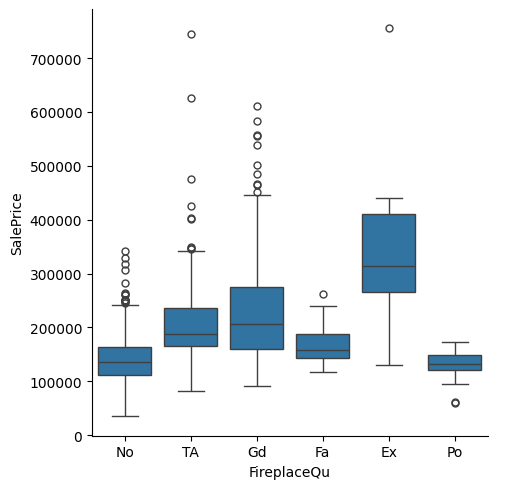

In [81]:
sns.catplot(data=train, x="FireplaceQu", y="SalePrice", kind="box")

In [82]:
train['LotFrontage'].fillna(0, inplace=True)
test['LotFrontage'].fillna(0, inplace=True)

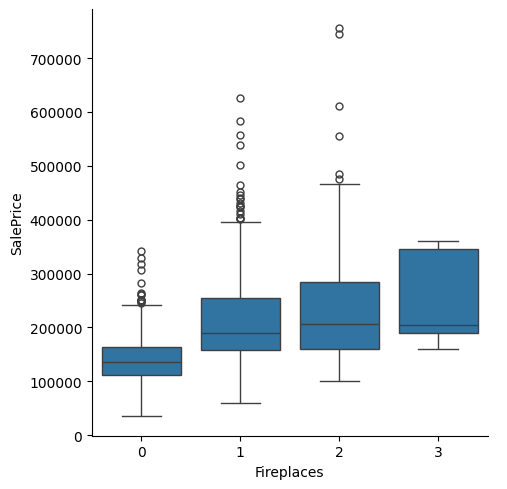

In [83]:
sns.catplot(data=train, x="Fireplaces", y="SalePrice", kind="box")

In [84]:
train['GarageYrBlt'].corr(train['YearBuilt'])

np.float64(0.8256674841743414)

In [85]:
train['GarageCond'].unique()

array(['TA', 'Fa', nan, 'Gd', 'Po', 'Ex'], dtype=object)

In [86]:
train['GarageCond'].fillna('No', inplace=True)
test['GarageCond'].fillna('No', inplace=True)

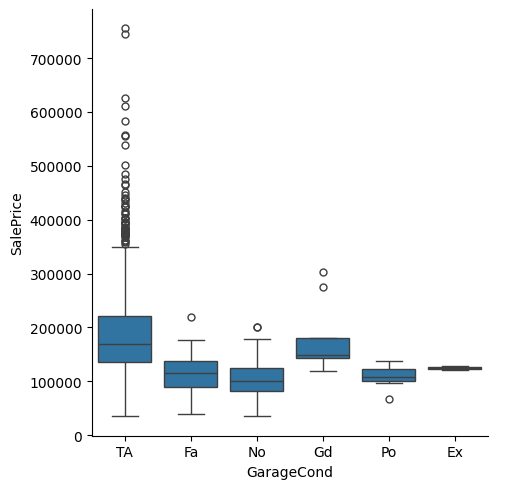

In [87]:
sns.catplot(data=train, x="GarageCond", y="SalePrice", kind="box")

In [88]:
train['GarageType'].fillna('No', inplace=True)
test['GarageType'].fillna('No', inplace=True)

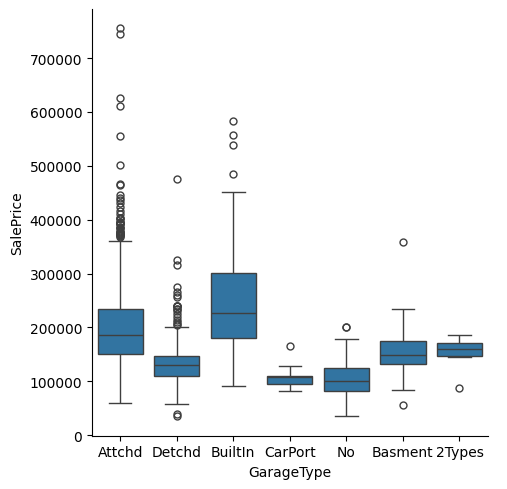

In [89]:
sns.catplot(data=train, x="GarageType", y="SalePrice", kind="box")

In [90]:
train['GarageFinish'].fillna('No', inplace=True)
test['GarageFinish'].fillna('No', inplace=True)

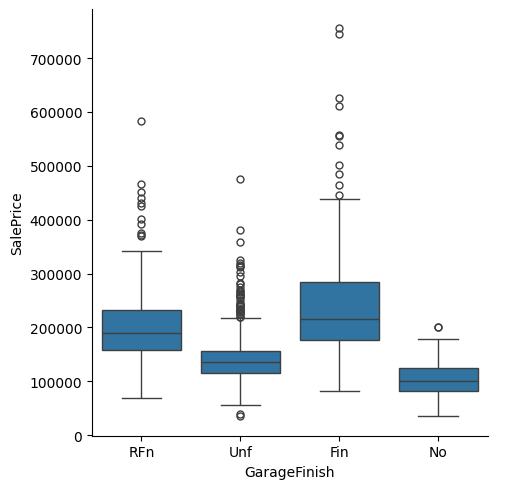

In [91]:
sns.catplot(data=train, x="GarageFinish", y="SalePrice", kind="box")

In [92]:
train['GarageQual'].fillna('No', inplace=True)
test['GarageQual'].fillna('No', inplace=True)

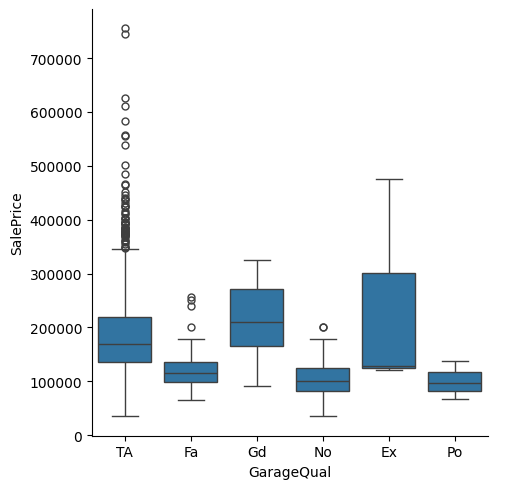

In [93]:
sns.catplot(data=train, x="GarageQual", y="SalePrice", kind="box")

In [94]:
train['BsmtFinType2'].unique()

array(['Unf', 'BLQ', nan, 'ALQ', 'Rec', 'LwQ', 'GLQ'], dtype=object)

In [95]:
train['BsmtFinType2'].fillna('Unf', inplace=True)
test['BsmtFinType2'].fillna('Unf', inplace=True)

In [96]:
train['BsmtExposure'].unique()

array(['No', 'Gd', 'Mn', 'Av', nan], dtype=object)

In [97]:
train['BsmtQual'].fillna('No', inplace=True)
test['BsmtQual'].fillna('No', inplace=True)

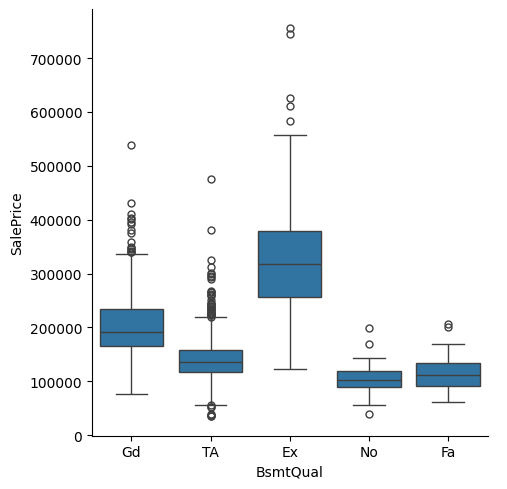

In [98]:
sns.catplot(data=train, x="BsmtQual", y="SalePrice", kind="box")

In [99]:
train['BsmtCond'].unique()

array(['TA', 'Gd', nan, 'Fa', 'Po'], dtype=object)

In [100]:
train['BsmtCond'].fillna('No', inplace=True)
test['BsmtCond'].fillna('No', inplace=True)

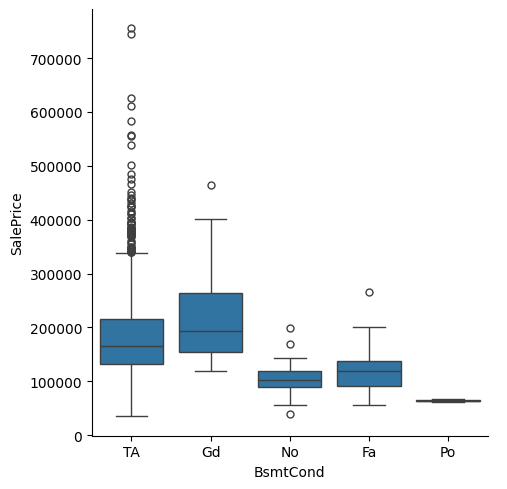

In [101]:
sns.catplot(data=train, x="BsmtCond", y="SalePrice", kind="box")

In [102]:
train['BsmtFinType1'].unique()

array(['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', nan, 'LwQ'], dtype=object)

In [103]:
train['BsmtFinType1'].fillna('Unf', inplace=True)
test['BsmtFinType1'].fillna('Unf', inplace=True)

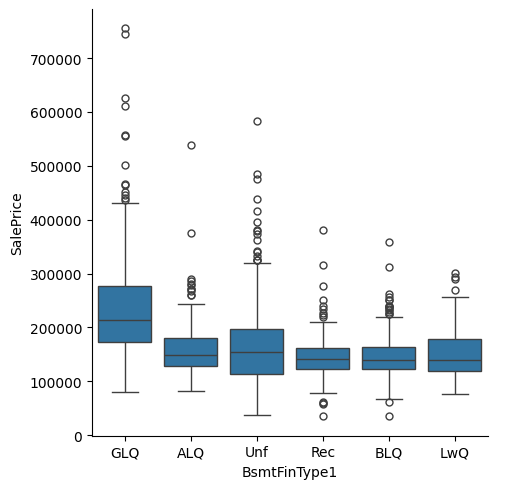

In [104]:
sns.catplot(data=train, x="BsmtFinType1", y="SalePrice", kind="box")

In [105]:
train['Electrical'].fillna('SBrkr', inplace=True)
test['Electrical'].fillna('SBrkr', inplace=True)

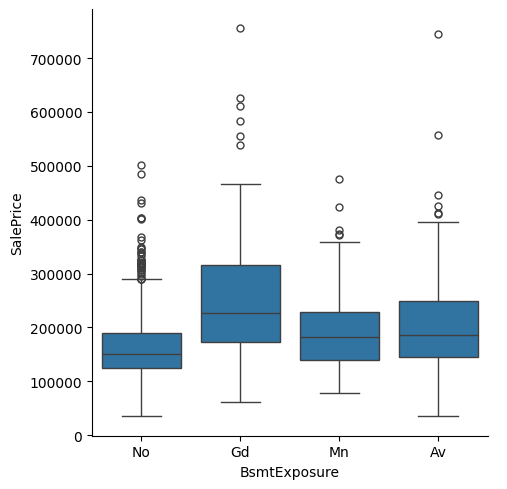

In [106]:
train['BsmtExposure'].fillna('No', inplace=True)
test['BsmtExposure'].fillna('No', inplace=True)
sns.catplot(data=train, x="BsmtExposure", y="SalePrice", kind="box")

In [107]:
pd.DataFrame(train.isnull().sum().sort_values(ascending=False)).head(20)

,0
PoolQC,1453
MiscFeature,1406
GarageYrBlt,81
MSSubClass,0
LotArea,0
Street,0
MSZoning,0
LotFrontage,0
LandContour,0
Utilities,0


## Feature Engineering

In [108]:
train = train.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'GarageYrBlt', 'GarageCond', 'BsmtFinType2', 'LowQualFinSF', 'MiscVal'])
test = test.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'GarageYrBlt', 'GarageCond', 'BsmtFinType2', 'LowQualFinSF', 'MiscVal'])

<Axes: >

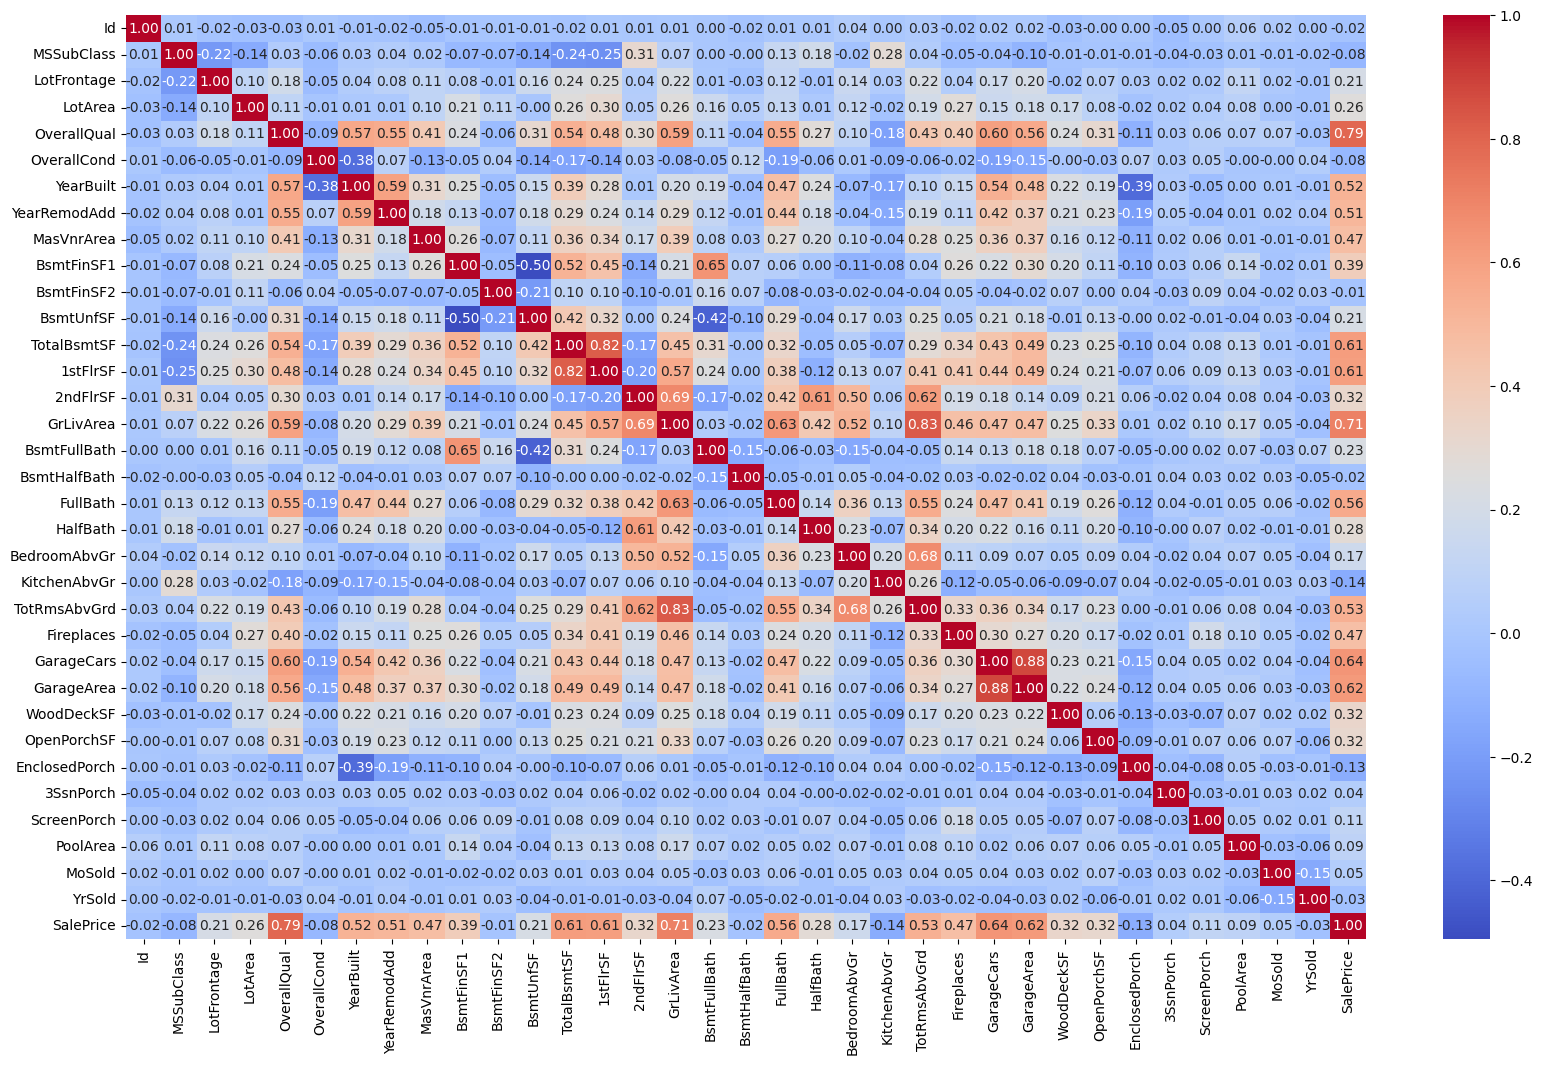

In [109]:
correlation_matrix = train.corr(numeric_only=True)
plt.figure(figsize=(20,12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

In [110]:
train = train.drop(columns=['GarageArea'])
test = test.drop(columns=['GarageArea'])

In [111]:
#Creating new features for train set


#Creating a new feature 'HouseAge' by subtracting 'YearBuilt' from 'YrSold'
train['HouseAge'] = train['YrSold'] - train['YearBuilt']

#Creating a new feature 'HouseRemodelAge' by subtracting 'YearRemodAdd' from 'YrSold'
train['HouseRemodelAge'] = train['YrSold'] - train['YearRemodAdd']

#Creating a new feature 'TotalBathrooms' by combining 'FullBath' and 'HalfBath'
train['TotalBathrooms'] = train['BsmtFullBath'] + train['FullBath'] + 0.5 * (train['HalfBath'] + train['BsmtHalfBath'])
#0.5 is used to count half bathrooms as a bathroom

#Creating a new feature 'HasPool' to indicate whether the house has a pool
train['HasPool'] = train['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
#.apply applies a function to each value in the column(0 no pool and 1 for pool)

#Creating a new feature 'TotalPorchSF' by combining all porch-related features
train['TotalPorchSF'] = train['OpenPorchSF'] + train['EnclosedPorch'] + train['3SsnPorch'] + train['ScreenPorch'] + train['WoodDeckSF']

#Creating a new feature 'TotalSF' by combining '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', and 'BsmtFinSF2'
train['TotalSF'] = train['1stFlrSF'] + train['2ndFlrSF'] + train['BsmtFinSF1'] + train['BsmtFinSF2']

#Creating a new feature 'TotalArea' by combining 'GrLivArea' and 'TotalBsmtSF'
train['TotalArea'] = train['GrLivArea'] + train['TotalBsmtSF']

#Drop the old columns
train = train.drop(columns=['YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'])


# Display the first 5 rows of the training set with the new features
print(train[['HouseAge', 'HouseRemodelAge', 'TotalBathrooms', 'HasPool', 'TotalPorchSF', 'TotalSF', 'TotalArea']].head())


   HouseAge  HouseRemodelAge  TotalBathrooms  HasPool  TotalPorchSF  TotalSF  \
0         5                5             3.5        0            61     2416   
1        31               31             2.5        0           298     2240   
2         7                6             3.5        0            42     2272   
3        91               36             2.0        0           307     1933   
4         8                8             3.5        0           276     2853   

   TotalArea  
0       2566  
1       2524  
2       2706  
3       2473  
4       3343  


In [112]:

# Create new features for the test set
test['HouseAge'] = test['YrSold'] - test['YearBuilt']
test['HouseRemodelAge'] = test['YrSold'] - test['YearRemodAdd']
test['TotalBathrooms'] = test['BsmtFullBath'] + test['FullBath'] + 0.5 * (test['HalfBath'] + test['BsmtHalfBath'])
test['HasPool'] = test['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
test['TotalPorchSF'] = test['OpenPorchSF'] + test['EnclosedPorch'] + test['3SsnPorch'] + test['ScreenPorch'] + test['WoodDeckSF']
test['TotalSF'] = test['1stFlrSF'] + test['2ndFlrSF'] + test['BsmtFinSF1'] + test['BsmtFinSF2']
test['TotalArea'] = test['GrLivArea'] + test['TotalBsmtSF']

# Drop unnecessary columns
test = test.drop(columns=['YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'])

# Display the first 5 rows of the test set with the new features
print(test[['HouseAge', 'HouseRemodelAge', 'TotalBathrooms', 'HasPool', 'TotalPorchSF', 'TotalSF', 'TotalArea']].head())

   HouseAge  HouseRemodelAge  TotalBathrooms  HasPool  TotalPorchSF  TotalSF  \
0        49               49             1.0        0           260   1508.0   
1        52               52             1.5        0           429   2252.0   
2        13               12             2.5        0           246   2420.0   
3        12               12             2.5        0           396   2206.0   
4        18               18             2.0        0           226   1543.0   

   TotalArea  
0     1778.0  
1     2658.0  
2     2557.0  
3     2530.0  
4     2560.0  


In [113]:
train.dtypes[train.dtypes=='object']

MSZoning         object
Street           object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
PavedDrive       object
SaleType         object
SaleCondition    object
dtype: object

In [114]:
train.dtypes[train.dtypes!='object']

Id                   int64
MSSubClass           int64
LotFrontage        float64
LotArea              int64
OverallQual          int64
OverallCond          int64
MasVnrArea         float64
BsmtUnfSF            int64
BedroomAbvGr         int64
KitchenAbvGr         int64
TotRmsAbvGrd         int64
Fireplaces           int64
GarageCars           int64
PoolArea             int64
MoSold               int64
SalePrice            int64
HouseAge             int64
HouseRemodelAge      int64
TotalBathrooms     float64
HasPool              int64
TotalPorchSF         int64
TotalSF              int64
TotalArea            int64
dtype: object

In [115]:
pd.DataFrame(train.isnull().sum().sort_values(ascending=False)).head(20)

,0
Id,0
MSSubClass,0
MSZoning,0
LotFrontage,0
LotArea,0
Street,0
LotShape,0
LandContour,0
Utilities,0
LotConfig,0


In [116]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,SaleType,SaleCondition,SalePrice,HouseAge,HouseRemodelAge,TotalBathrooms,HasPool,TotalPorchSF,TotalSF,TotalArea
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,WD,Normal,208500,5,5,3.5,0,61,2416,2566
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,WD,Normal,181500,31,31,2.5,0,298,2240,2524
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,WD,Normal,223500,7,6,3.5,0,42,2272,2706
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,WD,Abnorml,140000,91,36,2.0,0,307,1933,2473
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,WD,Normal,250000,8,8,3.5,0,276,2853,3343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,...,WD,Normal,175000,8,7,2.5,0,40,1647,2600
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,...,WD,Normal,210000,32,22,3.0,0,349,3026,3615
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,...,WD,Normal,266500,69,4,2.0,0,60,2615,3492
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,...,WD,Normal,142125,60,14,2.0,0,478,2156,2156


### Normalizing Data/Values

# Select only numeric columns
numeric_columns = train.select_dtypes(include=['int64', 'float64']).columns
numeric_data = train[numeric_columns]
#Issue with this is that, every numeric data is normalized which isn't what we want.

# List of continuous numerical features to normalize
continuous_features = [
    'OverallQual', 'TotalArea', 'TotalSF', 'GarageCars', 'TotalBathrooms', 
    'TotRmsAbvGrd', 'Fireplaces', 'MasVnrArea', 'TotalPorchSF', 'LotArea', 
    'BsmtUnfSF', 'BedroomAbvGr', 'LotFrontage', 'MoSold', 'PoolArea', 
    'HasPool', 'MiscVal', 'OverallCond', 'LowQualFinSF', 'MSSubClass', 
    'KitchenAbvGr'
]

#select only continuous features
continuous_data = train[continuous_features]

# Reset the index to avoid misalignment
continuous_data_reset = continuous_data.reset_index(drop=True)

# Display the selected features values
print(continuous_data.head())


# Initialize the MinMaxScaler
min_max_scaler = MinMaxScaler() # Scales the values to a range of 0 and 1


# Fit and transform the numeric data
#min_max_scaled_data = min_max_scaler.fit_transform(numeric_data)
# Fit and transform the continuous data
min_max_scaled_data = min_max_scaler.fit_transform(continuous_data_reset)

if np.any(np.isnan(min_max_scaled_data)) or np.any(np.isinf(min_max_scaled_data)):
    print("Warning: The scaling resulted in NaN or infinite values!")
else:
    print("No NaN or infinite values after scaling.")

# Convert the scaled data back to a DataFrame
#min_max_scaled_df = pd.DataFrame(min_max_scaled_data, columns=numeric_columns)
min_max_scaled_df = pd.DataFrame(min_max_scaled_data, columns=continuous_features)
# 'columnns=numeric_columns' makes sure the columns are the same as the original

# Replace original numeric data with the scaled data
#train[numeric_columns] = min_max_scaled_df
#train dataframe now contains normalized data
train[continuous_features] = min_max_scaled_df
print("-----------------------")
print("min_max_scaled_data")
print(train[continuous_features].head())

#Display the first 5 rows of the scaled data
print("-----------------------")
print("min_max_scaled_df")
print(min_max_scaled_df.head())

#Display the first 5 rows of the train dataframe
print("-----------------------")
print(train.head())

print(train[continuous_features].shape, min_max_scaled_df.shape)

min_max_scaled_data

min_max_scaled_df

continuous_data

# Select the same continuous features in the test set
test_continuous_data = test[continuous_features]

# Use the SAME scaler (already fitted on training data) to transform the test set
# DO NOT refit the scaler on the test data!
test_min_max_scaled_data = min_max_scaler.transform(test_continuous_data)

# Convert the scaled test data back to a DataFrame
test_min_max_scaled_df = pd.DataFrame(test_min_max_scaled_data, columns=continuous_features)

# Replace original continuous features in the test set with the scaled data
test[continuous_features] = test_min_max_scaled_df

# Display the first 5 rows of the scaled test data
print("-----------------------")
print("Scaled Test Data (Continuous Features):")
print(test[continuous_features].head())

# Verify the scaling (values should be between 0 and 1)
print("\nTest Data Min (should be ~0):")
print(test[continuous_features].min().round(2))
print("\nTest Data Max (should be ~1):")
print(test[continuous_features].max().round(2))

### Dropping Outliers

Chose to drop outliers here so I can normalize the data without issues

In [117]:
values = [598, 955, 935, 1299, 250, 314, 336, 707, 379, 1183, 692, 186, 441, 524, 739, 636, 1062, 1191, 496, 1338]
train = train[train.Id.isin(values) == False]
pd.DataFrame(train.isnull().sum().sort_values(ascending=False)).head(20)

,0
Id,0
MSSubClass,0
MSZoning,0
LotFrontage,0
LotArea,0
Street,0
LotShape,0
LandContour,0
Utilities,0
LotConfig,0


### Original One-Hot Encoding

One-Hot Encoding converts categorical variables into a binary format(0 or 1)

Before the pipline was created this was one hot encoding was used for certain features

In [118]:
# Select categorical columns (object data type)
#categorical_columns = train.select_dtypes(include=['object']).columns

#for feature in categorical_columns:
    #print(f"{feature}: {train[feature].unique()} unique values")


# Select only certain features
ohe_cols = ['HouseStyle', 'Heating', 'SaleType', 'MSZoning', 'Neighborhood', 'SaleCondition', 'MasVnrType']

#Features that I selected before
#['Street', 'LotConfig','Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
#'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd','MasVnrType','Foundation', 
#'Electrical',  'SaleType', 'MSZoning', 'SaleCondition', 'Heating', 'GarageType', 'RoofMatl']


#Turn these features into binary numbers
#train_encoded = pd.get_dummies(train, columns=ohe_cols, drop_first=True, dtype=float)
#test_encoded = pd.get_dummies(test, columns=ohe_cols, drop_first=True, dtype=float)
#drop_first removes one of the new columns to avoid redundancy
#dtype=float makes sure the data type is float

# Save original columns (includes engineered features)
#original_columns = train.columns.tolist()
# Get OHE columns (new columns added during encoding)
#ohe_features = train_encoded.columns.difference(original_columns).tolist()

#test_encoded = test_encoded.reindex(columns=train_encoded.columns, fill_value=0)

# Replace train and test with the encoded versions
#train = train_encoded
#test = test_encoded

# Take a look at the new columns
#encoded_BldgType_columns = [col for col in train.columns if 'BldgType' in col]
#print(train[encoded_BldgType_columns].head())



### Original Ordinal Encoding

Ordinal Encoding converts categorical variables into a ranking

Before pipeline was created this was how ordinal encoding was used


In [119]:
# Define categorical features for ordinal encoding
ode_cols = ['BsmtQual', 'BsmtFinType1', 'CentralAir', 'Functional', 'FireplaceQu', 
    'GarageFinish', 'KitchenQual', 'BsmtExposure', 'HeatingQC', 'ExterQual']

#Old ode cols
#['LotShape', 'LandContour', 'Utilities', 'LandSlope', 'BsmtQual', 
 #           'BsmtFinType1', 'CentralAir', 'Functional', 'FireplaceQu', 'GarageFinish', 
  #          'GarageQual', 'PavedDrive', 'ExterCond', 'KitchenQual', 'BsmtExposure', 
   #         'HeatingQC', 'ExterQual', 'BsmtCond']

# Apply ordinal encoding
#ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)  
#train[ode_cols] = ordinal_encoder.fit_transform(train[ode_cols])
#test[ode_cols] = ordinal_encoder.transform(test[ode_cols])

#### Feature Selection

Dropping useless features

In [120]:
#Select only the features I want to use (engineered + OHE) for the models
engineered_features = [
    'HouseAge', 'HouseRemodelAge', 'TotalBathrooms', 'HasPool', 
    'TotalPorchSF', 'TotalSF', 'TotalArea'
]
#drop features from old ode/ohe
# Features to drop (commented out ones)
drop_cols = [
    'LotShape', 'LandContour', 'Utilities', 'LandSlope', 'GarageQual', 'PavedDrive', 
    'ExterCond', 'BsmtCond', 'Street', 'LotConfig', 'Condition1', 'Condition2', 'BldgType', 
    'RoofStyle', 'Exterior1st', 'Exterior2nd', 'Foundation', 'Electrical', 'GarageType', 'RoofMatl'
]

# Drop the columns from train that are in the drop_cols list
train = train.drop(columns=[col for col in drop_cols if col in train.columns])
test = test.drop(columns=[col for col in drop_cols if col in test.columns])

#combine engineered features with one-hot encoded features

#selected_features = ohe_features + engineered_features + ode_cols

#selected_features

In [121]:
train.drop(columns=['Id'], inplace=True)

In [122]:
train

,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,HouseStyle,OverallQual,OverallCond,MasVnrType,MasVnrArea,...,SaleType,SaleCondition,SalePrice,HouseAge,HouseRemodelAge,TotalBathrooms,HasPool,TotalPorchSF,TotalSF,TotalArea
0,60,RL,65.0,8450,CollgCr,2Story,7,5,BrkFace,196.0,...,WD,Normal,208500,5,5,3.5,0,61,2416,2566
1,20,RL,80.0,9600,Veenker,1Story,6,8,No,0.0,...,WD,Normal,181500,31,31,2.5,0,298,2240,2524
2,60,RL,68.0,11250,CollgCr,2Story,7,5,BrkFace,162.0,...,WD,Normal,223500,7,6,3.5,0,42,2272,2706
3,70,RL,60.0,9550,Crawfor,2Story,7,5,No,0.0,...,WD,Abnorml,140000,91,36,2.0,0,307,1933,2473
4,60,RL,84.0,14260,NoRidge,2Story,8,5,BrkFace,350.0,...,WD,Normal,250000,8,8,3.5,0,276,2853,3343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Gilbert,2Story,6,5,No,0.0,...,WD,Normal,175000,8,7,2.5,0,40,1647,2600
1456,20,RL,85.0,13175,NWAmes,1Story,6,6,Stone,119.0,...,WD,Normal,210000,32,22,3.0,0,349,3026,3615
1457,70,RL,66.0,9042,Crawfor,2Story,7,9,No,0.0,...,WD,Normal,266500,69,4,2.0,0,60,2615,3492
1458,20,RL,68.0,9717,NAmes,1Story,5,6,No,0.0,...,WD,Normal,142125,60,14,2.0,0,478,2156,2156


In [123]:
pd.DataFrame(train.isnull().sum().sort_values(ascending=False)).head(20)
num_cols = train.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop('SalePrice')
num_cols

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'BsmtUnfSF', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'PoolArea', 'MoSold',
       'HouseAge', 'HouseRemodelAge', 'TotalBathrooms', 'HasPool',
       'TotalPorchSF', 'TotalSF', 'TotalArea'],
      dtype='object')

## Model Development

In [124]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [125]:
ode_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

In [126]:
ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [127]:
col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ode_p', ode_pipeline, ode_cols),
    ('ohe_p', ohe_pipeline, ohe_cols),
    ],
    remainder='passthrough', 
    n_jobs=-1)

In [128]:
pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])

In [129]:
X = train.drop('SalePrice', axis=1)
y = train['SalePrice']

In [130]:
X_preprocessed = pipeline.fit_transform(X)

### Train/Test Split

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=25)

In [132]:
X_preprocessed

array([[ 0.07859453,  0.24150544, -0.28737849, ...,  1.        ,
         0.        ,  0.        ],
       [-0.87346535,  0.69654013, -0.07266855, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.07859453,  0.33251238,  0.23539353, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.3166095 ,  0.27184109, -0.17684955, ...,  0.        ,
         1.        ,  0.        ],
       [-0.87346535,  0.33251238, -0.05082415, ...,  0.        ,
         1.        ,  0.        ],
       [-0.87346535,  0.5448619 , -0.00974921, ...,  0.        ,
         1.        ,  0.        ]], shape=(1440, 94))

### Linear Regression Model

In [133]:
#initialize model
lr = LinearRegression()

#train the model on the training data
lr.fit(X_train, y_train)

#make predictions based on the validation set
y_pred_lr = lr.predict(X_test)

#evaluate the model using Root Mean Squared Error
# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred_lr)

# Compute Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print(f"Validation RMSE: {rmse:.2f}")


Validation RMSE: 28459.58


### Random Forest Regressor Model

In [134]:
Rfr = RandomForestRegressor(random_state=13)

param_grid_Rfr = {
   'max_depth': [5, 10, 15],
   'n_estimators': [100, 250, 500],
   'min_samples_split': [3, 5, 10]
}
Rfr_cv = GridSearchCV(Rfr, param_grid_Rfr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

Rfr_cv.fit(X_train, y_train)

# Cross-validation scores
cv_scores_rf = cross_val_score(Rfr_cv.best_estimator_, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print("Random Forest Cross-Validation RMSE Scores: ", -cv_scores_rf)


print(np.sqrt(-1 * Rfr_cv.best_score_))

Rfr_cv.best_params_

Random Forest Cross-Validation RMSE Scores:  [20602.20901492 24496.1226106  22470.16368524 25850.6271188
 26055.00580088]
23985.568765438955


{'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 500}

### RFE for Feature Selection

In [135]:
# Initialize model and RFE
model = LinearRegression()
rfe = RFE(model, n_features_to_select=10)  # Select top 10 features

# Fit RFE on training data
rfe.fit(X_train, y_train)

# Get selected feature indices
selected_indices = rfe.support_

# Since preprocessing removed original feature names, use the transformer column names
feature_names = pipeline.named_steps['preprocessing'].get_feature_names_out()

X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Get selected feature names
selected_features = feature_names[selected_indices]
print("Selected Features:", selected_features)

Selected Features: ['num_p__OverallQual' 'num_p__TotalSF' 'ohe_p__Heating_Floor'
 'ohe_p__Heating_GasW' 'ohe_p__Heating_OthW' 'ohe_p__SaleType_Con'
 'ohe_p__SaleType_New' 'ohe_p__Neighborhood_NoRidge'
 'ohe_p__Neighborhood_NridgHt' 'ohe_p__Neighborhood_StoneBr']


### XGBoost for Feature Selection

In [136]:
# Train XGBoost model
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

# Extract feature importance
features_importance = pd.Series(xgb.feature_importances_, index=feature_names).sort_values(ascending=False)
print(features_importance.head(30))

num_p__OverallQual              0.468398
num_p__TotalArea                0.114055
ohe_p__MSZoning_RM              0.068252
ode_p__KitchenQual              0.043723
num_p__TotalSF                  0.031473
ode_p__BsmtQual                 0.026243
num_p__TotalBathrooms           0.017342
num_p__Fireplaces               0.012769
ohe_p__HouseStyle_2Story        0.012597
ohe_p__Neighborhood_Somerst     0.011778
ode_p__CentralAir               0.010251
ohe_p__Neighborhood_Crawfor     0.009921
ohe_p__Neighborhood_NAmes       0.009443
ohe_p__MSZoning_RL              0.009087
ohe_p__Neighborhood_StoneBr     0.009031
num_p__HouseRemodelAge          0.008860
num_p__GarageCars               0.008279
num_p__OverallCond              0.008175
num_p__HouseAge                 0.007903
ohe_p__SaleCondition_Normal     0.007309
ohe_p__Neighborhood_Timber      0.007302
ohe_p__SaleCondition_Abnorml    0.006493
num_p__LotArea                  0.006122
ohe_p__SaleType_WD              0.006002
ode_p__GarageFin

### Evaluation and Comparison

In [137]:
#rmse = mean_squared_error(y_val, y_pred_lr, squared=False)  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred_lr)  # Mean Absolute Error
r2 = r2_score(y_test, y_pred_lr)  # R-squared value

#how much the predicted values deviate from the actual values
#lower is better performance
print(f"Root Mean Squared Error (RMSE): {rmse}")  

#average absolute differences between actual and predicted values
print(f"Mean Absolute Error (MAE): {mae}")  

#how well the model explains the variance in the target variable
print(f"R-squared (R2): {r2}")
#1 = perfect fit
#0 = model performs no better than predicting the mean of target variable 
#<0 = model performs worse than predicting the mean of target variable

Root Mean Squared Error (RMSE): 28459.578707004937
Mean Absolute Error (MAE): 18081.8575869952
R-squared (R2): 0.8860260194027426


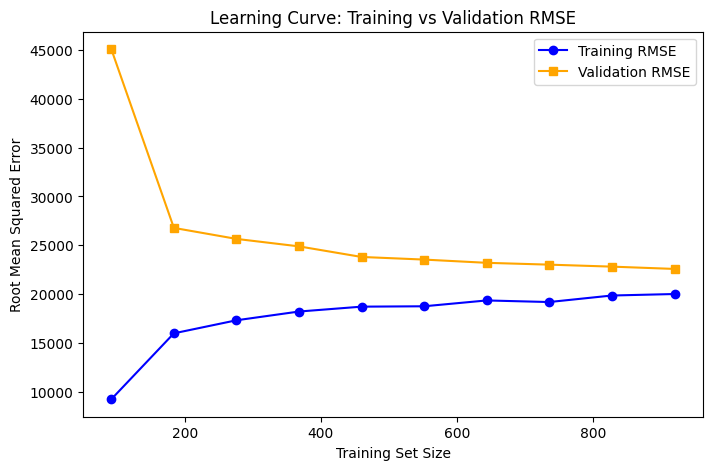

In [138]:
#Predict on training and validation sets
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

#Calculate RMSE
rmse_train = root_mean_squared_error(y_train, y_train_pred)
rmse_test = root_mean_squared_error(y_test, y_test_pred)

# Plot RMSE for training and validation sets
# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    lr, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error", train_sizes=np.linspace(0.1, 1.0, 10)
)

# Convert negative RMSE back to positive values
train_rmse = -np.mean(train_scores, axis=1)
test_rmse = -np.mean(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_rmse, marker='o', label="Training RMSE", color="blue")
plt.plot(train_sizes, test_rmse, marker='s', label="Validation RMSE", color="orange")

plt.xlabel("Training Set Size")
plt.ylabel("Root Mean Squared Error")
plt.title("Learning Curve: Training vs Validation RMSE")
plt.legend()
plt.show()

#Overfitting -> training RMSE is much lower than validation RMSE
#Underfitting-> Both training and validation RMSE are high and close together
#Good fit -> training and validation RMSE decrease and stabilize at similar values

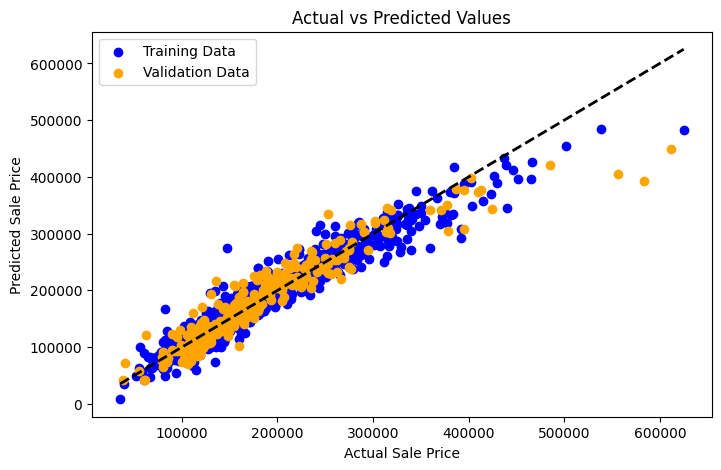

In [139]:
plt.figure(figsize=(8, 5))
plt.scatter(y_train, y_train_pred, color="blue", label="Training Data")
plt.scatter(y_test, y_test_pred, color="orange", label="Validation Data")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.show()


### XGBoost Regressor Model

In [140]:
XGB = XGBRegressor(random_state=13)

param_grid_XGB = {
    'learning_rate': [0.05, 0.1, 0.2], 
    'n_estimators': [300],
    'max_depth': [3],
    'min_child_weight': [1,2,3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

xgb_cv = GridSearchCV(XGB, param_grid_XGB, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

xgb_cv.fit(X_train, y_train)

print(np.sqrt(-1 * xgb_cv.best_score_))
print("Best XGBoost Parameters: ", xgb_cv.best_params_)

21259.92637177592
Best XGBoost Parameters:  {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


*learning_rate*: controls how quickly the model adapts; Lower values = slower learning, but can lead to better generalization(the model's performance on data it hasn't seen before).

*n_estimators*: the number of trees(or models) used. More trees can improve accuracy, but too many might slow down training.

*max_depth*: how deep each tree is allowed to grow. A deeper tree might capture too many details from the training data and perform poorly on new data(overfitting).

*min_child_weight, gamma, subsample, colsample_bytree*: These control different aspects of the model's complexity. They help balance between fitting the training data well and being flexible enough to work on new data.

#### gridsearch
cv is cross-validation, split the data into 3 parts
scoring is a performance metric
n_jobs=-1 means using all CPU cores used to speed up the process

### Ridge CV Model

In [141]:
# Define the model
ridge = Ridge()

# Define the parameter grid
param_grid_ridge = {
    'alpha': [0.05, 0.1, 1, 3, 5, 10],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag']  
}

# Perform GridSearchCV
ridge_search = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
ridge_search.fit(X_train, y_train)

# Best hyperparameters from GridSearchCV
print("Best Ridge Parameters: ", ridge_search.best_params_)

#best score
print(np.sqrt(-1 * ridge_search.best_score_))

# Cross-validation scores
cv_scores = cross_val_score(ridge_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print("Ridge Cross-Validation RMSE Scores: ", -cv_scores)


Best Ridge Parameters:  {'alpha': 5, 'solver': 'sparse_cg'}
22141.20319883002
Ridge Cross-Validation RMSE Scores:  [20448.26518159 22872.80539214 21570.98365883 21782.6012168
 23876.31814657]


### Gradient Boosting Regressor CV Model

In [142]:
GBR = GradientBoostingRegressor()

param_grid_GBR = {
    'max_depth': [12, 15, 20], 
    'n_estimators': [200, 300, 1000],
    'min_samples_leaf': [10, 25, 50],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_features': [0.01, 0.1, 0.7]
}

GBR_cv = GridSearchCV(GBR, param_grid_GBR, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

GBR_cv.fit(X_train, y_train)

print(np.sqrt(-1 * GBR_cv.best_score_))

# Best hyperparameters from GridSearchCV
print("Best GBR Parameters: ", GBR_cv.best_params_)

# Cross-validation scores
cv_scores = cross_val_score(GBR_cv.best_estimator_, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print("GBR Cross-Validation RMSE Scores: ", -cv_scores)

20877.830855450055
Best GBR Parameters:  {'learning_rate': 0.01, 'max_depth': 20, 'max_features': 0.1, 'min_samples_leaf': 10, 'n_estimators': 1000}
GBR Cross-Validation RMSE Scores:  [17584.42494626 21876.94825858 20593.12346002 21193.91673889
 23245.39322507]


**max_depth**: limits number of nodes in the tree for performance

**n_estimators**: number of trees to build, GBR is robust to over-fitting, so a large number usually results in better performance.

**min_samples_leaf**: the minimum number of samples required to be at a leaf node, can lead to better generalization(better performance on data it hasn't seen before)

**learning_rate**: how fast this model can learn, model learns slowly which requires more trees to achieve good performance and more robust results

**max_features**: selects a percentage of features, introduces randomness and can reduce overfitting

### LGBM Regressor CV Model

In [143]:
lgbm_regressor = lgb.LGBMRegressor(min_child_samples=None)

param_grid_lgbm = {
    'min_data_in_leaf': [10, 20, 30],
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

lgbm_cv = GridSearchCV(lgbm_regressor, param_grid_lgbm, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

lgbm_cv.fit(X_train, y_train)

print(np.sqrt(-1 * lgbm_cv.best_score_))

# Best hyperparameters from GridSearchCV
print("Best LBBM Parameters: ", lgbm_cv.best_params_)

# Cross-validation scores
cv_scores = cross_val_score(lgbm_cv.best_estimator_, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print("LBBM Cross-Validation RMSE Scores: ", -cv_scores)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1900
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 75
[LightGBM] [Info] Start training from score 178064.547743
22831.31187747373
Best LBBM Parameters:  {'boosting_type': 'gbdt', 'learning_rate': 0.05, 'min_data_in_leaf': 10, 'n_estimators': 200, 'num_leaves': 20}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1798
[LightGBM] [Info] Number of data points in the train set: 921, number of used features: 71
[LightGBM] [Info] Start training from score 179840.757872
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.0003

C:\Users\owenl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\owenl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\owenl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\owenl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1789
[LightGBM] [Info] Number of data points in the train set: 922, number of used features: 69
[LightGBM] [Info] Start training from score 178773.828633
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1786
[LightGBM] [Info] Number of data points in the train set: 922, number of used features: 70
[LightGBM] [Info] Start training from score 176970.060738
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1782
[LightGBM] [Info] Number of data points in the train set: 922, number of used features: 69
[LightGBM] [Info] Start

C:\Users\owenl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


**boosting_type**: determines which algorithm used for boosting, 'gbdt' is Gradient boosting decision tree(corrects previous errors) and 'dart' is Dropouts meet Multiple additive regression trees(reduces overfitting)

**num_leaves**: sets the maximum number of leaves(terminal nodes) in one tree, higher number of leaves increases model's complexity, allowing it to capture more detailed patterns-but it can also lead to overfitting if set too high.

**min_data_in_leaf**: specifies the minimum number of data samples(rows) that must exist in a leaf(end node) of a tree, too low can lead to overfitting, too high can lead to underfitting


### Voting Regressor Model

In [144]:
vr = VotingRegressor([('gbr', GBR_cv.best_estimator_),
                      ('xgb', xgb_cv.best_estimator_),
                      ('ridge', ridge_search.best_estimator_)],
                     weights=[2,3,1]) #assigning weights to models(higher means more influence)

vr.fit(X_train, y_train)

y_pred_vr = vr.predict(X_test)

print(root_mean_squared_error(y_test, y_pred_vr))



25968.898624839392


### Stacking Regressor Model

In [145]:
estimators = [ ('gbr', GBR_cv.best_estimator_),
    ('xgb', xgb_cv.best_estimator_),
    ('lgb', lgbm_cv.best_estimator_),
    ('rfr', Rfr_cv.best_estimator_),
]

stackreg = StackingRegressor(
    estimators = estimators,
    final_estimator = vr 
)

stackreg.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1900
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 75
[LightGBM] [Info] Start training from score 178064.547743
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1798
[LightGBM] [Info] Number of data points in the train set: 921, number of used features: 71
[LightGBM] [Info] Start training from score 179840.757872
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1796
[LightGBM] [Info] Number of data points in the train set: 921, number of used features: 70
[LightGBM] [Info] Star

C:\Users\owenl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\owenl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\owenl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\owenl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1782
[LightGBM] [Info] Number of data points in the train set: 922, number of used features: 69
[LightGBM] [Info] Start training from score 177956.335141


C:\Users\owenl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


StackingRegressor(estimators=[('gbr',
                               GradientBoostingRegressor(learning_rate=0.01,
                                                         max_depth=20,
                                                         max_features=0.1,
                                                         min_samples_leaf=10,
                                                         n_estimators=1000)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=1.0, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval...
                                                                            interaction_constraints=None,
                                                                            learning_rate=0.05,
                                                                            max_bin=None,
                                                                            max_cat_threshold=None,
                                                                            max_cat_to_onehot=None,
                                                                            max_delta_step=None,
                                                                            max_depth=3,
                                                                            max_leaves=None,
                                                                            min_child_weight=3,
                                                                            missing=nan,
                                                                            monotone_constraints=None,
                                                                            multi_strategy=None,
                                                                            n_estimators=300,
                                                                            n_jobs=None,
                                                                            num_parallel_tree=None,
                                                                            random_state=13, ...)),
                                                              ('ridge',
                                                               Ridge(alpha=5,
                                                                     solver='sparse_cg'))],
                                                  weights=[2, 3, 1]))

In [146]:
y_pred_stack = stackreg.predict(X_test)

print(root_mean_squared_error(y_test, y_pred_stack))

26114.842936721645


C:\Users\owenl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


## Kaggle Submission

In [147]:
test_preprocess = pipeline.transform(test)

preds_log = stackreg.predict(test_preprocess)
print(preds_log[:10])

y_stacking = stackreg.predict(test_preprocess)

y_stacking_out = test[['Id']]
y_stacking_out.loc[:, 'SalePrice'] = y_stacking

y_stacking_out.to_csv('stacking_submission.csv', index=False)

C:\Users\owenl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[125143.62916696 164938.9311662  182405.33073193 195094.61439343
 179050.20450389 171876.83087535 172736.16331564 173371.80999864
 179572.17832555 128797.26820391]


C:\Users\owenl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\owenl\AppData\Local\Temp\ipykernel_16836\2764288836.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_stacking_out.loc[:, 'SalePrice'] = y_stacking


## Exporting Model for App

In [148]:
# Export the trained stacking regressor using pickle
with open('stacking_model1.pkl', 'wb') as f:
    pickle.dump(stackreg, f)

In [149]:
with open('preprocessing_pipeline1.pkl', 'wb') as f:
    pickle.dump(pipeline, f)  # Save the preprocessing pipeline

print(pipeline)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('num_p',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'BsmtUnfSF', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', '...
                                                   'CentralAir', 'Functional',
                                                   'FireplaceQu',
                                                   'GarageFinish',
                                                

In [150]:
# Get the expected feature names
expected_features = pipeline.feature_names_in_

# Save the expected features list
with open('expected_features1.pkl', 'wb') as f:
    pickle.dump(expected_features, f)

print(expected_features)  # Print to check

['MSSubClass' 'MSZoning' 'LotFrontage' 'LotArea' 'Neighborhood'
 'HouseStyle' 'OverallQual' 'OverallCond' 'MasVnrType' 'MasVnrArea'
 'ExterQual' 'BsmtQual' 'BsmtExposure' 'BsmtFinType1' 'BsmtUnfSF'
 'Heating' 'HeatingQC' 'CentralAir' 'BedroomAbvGr' 'KitchenAbvGr'
 'KitchenQual' 'TotRmsAbvGrd' 'Functional' 'Fireplaces' 'FireplaceQu'
 'GarageFinish' 'GarageCars' 'PoolArea' 'MoSold' 'SaleType'
 'SaleCondition' 'HouseAge' 'HouseRemodelAge' 'TotalBathrooms' 'HasPool'
 'TotalPorchSF' 'TotalSF' 'TotalArea']
